![](https://neurohive.io/wp-content/uploads/2018/08/perseptron-mnogosloinyi.gif)

# Семинар 8: кошки против собак и transfer learning 

На следующих нескольких семинарах мы попытаемся обучить нейросетку отличать кошек от собак. Если вы ещё не забыли лекцию про свёрточные сетки, в $2013$ году это было непростой задачкой. Настолько, что [к соревнованию на Kaggle](https://www.kaggle.com/c/dogs-vs-cats) висит такое предысловие:

> В 1997 году Deep Blue обыграл в шахматы Каспарова.  В 2011 Watson обставил чемпионов Jeopardy. Сможет ли ваш алгоритм в 2013 году отличить Бобика от Пушистика?

В этом семинаре мы попробуес сделать Transfer learning и посмотрим какое качество будет у нашей модели.

# Что такое transfer learning? 

Каждый раз, обучая нейронку, мы сначала рандомно инициализируем веса, а после в ходе бэкпропа обучаем модель. Если мы сразу же угадываем хорошие веса, модель сходится быстрее. Иногда можно брать в качестве инициализации веса, полученные другими исследователями и на их основе дообучать модель под свой выход. Это здорово упрощает задачу обучения и экономит недели работы.

- __Transfer learning__ - это когда ты заморозил все веса, кроме последних слоёв, а последнии слои дообучил под свою задачу 
- __Fine-tuning__ - это когда ты использовал веса предобученной модели как инициализацию и менял в ходе дообучения все веса модели

In [1]:
import tensorflow as tf
tf.__version__ 

'2.8.0'

In [2]:
from tensorflow.keras import Sequential, Model, layers

import numpy as np
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Реквизируем MobileNet 

На лекциях мы обсуждали с вами то, как люди ImageNet рвали. Мы обсудили довольно много архитектур в ходе этого обсуждения. Все эти предобученные на ImageNet модели есть в Tensorflow. Мы можем использовать их для решения своих задач. 

Давайте попробуем взять [архитектуру MobileNetV2](https://arxiv.org/abs/1801.04381) и применить к нашей задаче. Эта модель была собрана и обучена на ImageNet в апреле 2018 года. Если говорить грубо, MobileNet это почти как Inception, но меньше. 

In [3]:
# как зоопарк подгружаем, азазазазаз
import tensorflow.keras.applications as zoo  

Попробуем взять из зоопарка предобученную модель и применить её для прогнозирования.

In [4]:
model = zoo.MobileNetV2(include_top=True, weights='imagenet')

In [5]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Опция `weights` отвечает за то, на каком датасете предобучена модель. Опция `include_top` отвечает за то, скачиваем мы модель полностью или только `feature extractor`, то есть только первые слои. Мы скачали всё. 

In [6]:
# Узнаем размерность входа и выхода
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

In [7]:
# 1000 классов wow
model.layers[-1].output_shape

(None, 1000)

Теперь попробуем что-нибудь спрогнозировать. В модуле `keras.utis` есть функция `get_file`, которая умеет скачивать и разархивировать разные файлы. Будем использовать её для скачки картинок по ссылкам. 

/root/.keras/datasets/cat2.jpg


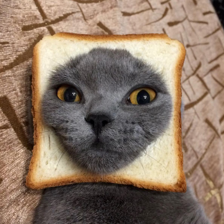

In [8]:
from tensorflow.keras.utils import get_file

import PIL.Image
import numpy as np

href = 'https://pro-kotikov.ru/wp-content/uploads/2019/02/kotohleb-photo-6.jpg'
image = get_file('cat2.jpg', href)

print(image) # паппка куда скачалась картинка 

image = PIL.Image.open(image).resize(input_shape)
image 

In [9]:
!ls -lah /root/.keras/models

total 14M
drwxr-xr-x 2 root root 4.0K Apr 20 13:54 .
drwxr-xr-x 4 root root 4.0K Apr 20 13:46 ..
-rw-r--r-- 1 root root  35K Apr 20 13:54 imagenet_class_index.json
-rw-r--r-- 1 root root  14M Apr 20 13:41 mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224.h5


Используем предобработку от разработчиков модели.

In [10]:
image = zoo.mobilenet_v2.preprocess_input(np.array(image))
image.min(), image.max() # картинка отнормировалась на отрезок [-1; 1]

(-1.0, 1.0)

Предобработка довольно ожидаемая :) 

In [11]:
image.shape

(224, 224, 3)

In [12]:
image[None, :, :, :].shape

(1, 224, 224, 3)

In [13]:
np.array([image]).shape

(1, 224, 224, 3)

In [14]:
# вот так можно добавить фиктивную размерность
image[np.newaxis,:,:,:].shape

(1, 224, 224, 3)

In [15]:
# строим прогноз 
result = model.predict(image[np.newaxis,:,:,:])
result.shape

(1, 1000)

In [16]:
result[0][:10]

array([2.8502141e-04, 1.0686082e-04, 2.2926459e-04, 1.4452697e-04,
       6.8274858e-05, 1.3019014e-04, 3.1848604e-04, 2.3902952e-05,
       4.0521474e-05, 4.1536728e-04], dtype=float32)

Готово! У нас есть $1000$ вероятностей. Посмотрем какой из классов вероятнее всего.

In [17]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

384

In [18]:
result[0].argsort()[-5:][::-1] # топ-5 классов

array([384, 370, 434, 383, 380])

Осталось только выяснить что это за класс. Для этого нам нужны метки Imagenet. Скачаем их. Они тоже уже есть в пакете. Удобно. 

In [19]:
zoo.mobilenet_v2.decode_predictions(result)[0]

[('n02500267', 'indri', 0.63395417),
 ('n02484975', 'guenon', 0.037894882),
 ('n02808304', 'bath_towel', 0.032159973),
 ('n02497673', 'Madagascar_cat', 0.027128508),
 ('n02493509', 'titi', 0.020611629)]

Объединим всё, что мы сделали выше в функцию для строительства прогнозов и попробуем ещё.

In [20]:
def save_image(href, save_name):
    img = get_file(save_name, href)
    return img

def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # тут чуть подрбнее про ресайзы: https://habr.com/ru/post/247219/
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Предобрабатываем картинку и добавляем лишнюю размерность
    img_array = zoo.mobilenet_v2.preprocess_input(np.array(img_resized))[np.newaxis, ...]

    # строим прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = zoo.mobilenet_v2.decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

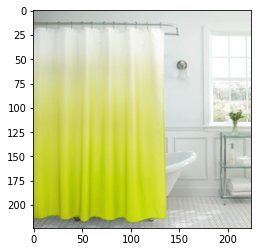

98.38% : shower_curtain
 0.77% : window_shade
 0.16% : sliding_door
 0.09% : theater_curtain
 0.05% : tub


In [21]:
href = 'https://images-na.ssl-images-amazon.com/images/I/91NKh-FPcBL._SL1500_.jpg'
path = save_image(href, 'shower_curtain.jpg')
predict(path)

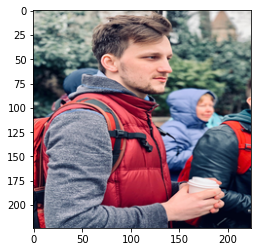

10.23% : stretcher
 9.10% : backpack
 3.21% : rugby_ball
 3.18% : academic_gown
 2.59% : stethoscope


In [22]:
href = 'https://sun9-34.userapi.com/c850216/v850216669/110118/s1XSv_XLgtY.jpg'
path = save_image(href, 'the_most_awesome_boy.jpg')
predict(path)

__Последняя картинка сильно исказилась.__  Можно дать этому искажению бой. Например, можно попробовать её обрезать. Создание хорошей предобработки изображений перед использованием нейронной сети - отдельная полноценная задача, которую решают перед её обучением. 

Давайте попробуем написать в numpy функцию, которая будет заниматься обрезанием картинок вот по такой схеме: 

<img src="https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/week3/images/center_crop.jpg" style="width:50%">

__Задание 1:__ напишите функцию, которая обрезала бы картинку. 

In [23]:
# Функция для обрезания картинок 
def image_center_crop(img):
    w = img.shape[0]
    h = img.shape[1]
    
    if w > h:
        cropped_img = img[(w - h)//2 : w - (w - h)//2, :, :]
    elif h > w:
        cropped_img = img[:, (h - w)//2 : h - (h - w)//2, :]
    else:
        cropped_img = img
    return cropped_img

Вставим эту функцию в построение прогнозов. 

In [24]:
def predict(image_path):
    # Подгружаем изображение и делаем его ресайз в соответсвии с моделью
    img = PIL.Image.open(image_path)
    
    # Обрезали части 
    img = image_center_crop(np.array(img))
    
    # тут чуть подрбнее про ресайзы: https://habr.com/ru/post/247219/
    img_resized = PIL.Image.fromarray(img).resize(input_shape)

    # Рисуем картинку
    plt.imshow(img_resized)
    plt.show()

    # Предобрабатываем картинку и добавляем лишнюю размерность
    img_array = zoo.mobilenet_v2.preprocess_input(np.array(img_resized))[np.newaxis, ...]

    # строим прогноз
    pred = model.predict(img_array)
    
    # Декодируем прогноз
    pred_decoded = zoo.mobilenet_v2.decode_predictions(pred)[0]

    # Печатаем его на экран
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

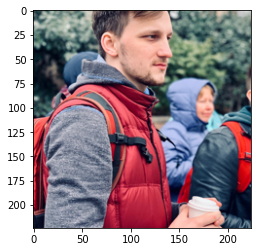

34.83% : stretcher
 5.08% : backpack
 2.78% : whistle
 2.78% : stole
 2.36% : bearskin


In [25]:
href = 'https://sun9-34.userapi.com/c850216/v850216669/110118/s1XSv_XLgtY.jpg'
path = save_image(href, 'the_most_awesome_boy.jpg')
predict(path)

Прогноз, по-прежнему, очень странный. Дело в том, что в `ImageNet` нет людей. Поэтому нейросетка не может выдать адекватный прогноз. 

In [26]:
########################################################################
###  Попробуйте подгрузить и классифицировать свою картинку 
########################################################################

# 2. Transfer learning

Побаловались с прогнозами, теперь давайте займёмся более серьёзными проблемами, а именно прогнозированием котиков и пёсиков.

## 2.1 Поставка данных 

Подгрузим данные и посмотрим на них. Себе данные заберём из гуглового хранилища. Всё тот же волшебный `get_file` из Keras заботливо скачает их для нас и разложит по папочкам вот в такую структуру: 

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

In [50]:
# Скачаем и разархивируем данные 
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip && unzip -q cats_and_dogs_filtered.zip

--2022-04-20 14:21:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 108.177.13.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   158MB/s    in 0.4s    

2022-04-20 14:21:38 (158 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:
!rm cats_and_dogs_filtered.zip
!ls

cats_and_dogs_filtered	sample_data


In [29]:
!ls cats_and_dogs_filtered/train

cats  dogs


In [30]:
# Другой подход 
# import zipfile

# url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# # папка, где будет лежать архив с файлами
# zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=url, extract=True)

# with zipfile.ZipFile(zip_dir, "r") as zip_ref:
#     zip_ref.extractall("targetdir")

Достанем в отдельные переменные все интересующие нас пути к данным.

In [31]:
wd = !pwd
path = wd[0] + '/'
path

'/content/'

In [32]:
import os 
xd = os.listdir(path + 'cats_and_dogs_filtered/train/dogs')
xc = os.listdir(path + 'cats_and_dogs_filtered/train/cats')
len(xd), len(xc)

(1000, 1000)

In [33]:
import os 
xd = os.listdir(path + 'cats_and_dogs_filtered/validation/dogs')
xc = os.listdir(path + 'cats_and_dogs_filtered/validation/cats')

test_cnt = len(xd) + len(xc)
len(xd), len(xc)

(500, 500)

Данных у нас не очень много. Всего лишь $1000$ примеров для обучения и $500$ для теста и валидации. 

Поработаем с данными. Обычно, когда картинок очень много, неудобно загружать их все в оперативную память. Для таких ситуаций пишут итераторы. [Много примеров таких итераторов можно найти в документации](https://www.tensorflow.org/tutorials/load_data/images)

In [34]:
root_train = path + 'cats_and_dogs_filtered/train'
root_test = path + 'cats_and_dogs_filtered/validation'

Напишем функцию, которая будет подгружать картинку с компьютера и предобрабатывать её для нас. 

In [35]:
train_ds = tf.data.Dataset.list_files(root_train + "/*/*.jpg", shuffle=True)

# дробим тест на валидацию и тест
test_list = tf.data.Dataset.list_files(root_test + "/*/*.jpg", shuffle=True)
val_size = int(test_cnt * 0.2)

test_ds = test_list.skip(val_size)
val_ds = test_list.take(val_size)

Посмотрим на размеры. 

In [36]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

2000
200
800


Напишем пару функций. Первая будет преобразовывать путь к файлу в номер класса. Вторая будет делать предобработку картинки и подгружать её в память компьютера. 

In [37]:
INPUT_SHAPE = (224, 224)

In [38]:
os.sep

'/'

In [39]:
def get_label(filename, class_names = ['cats', 'dogs']):
    parts = tf.strings.split(filename, os.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [40]:
test_img = "/content/cats_and_dogs_filtered/train/cats/cat.200.jpg"

In [41]:
get_label(test_img).numpy()

0

In [42]:
def decode_img(img, img_shape=INPUT_SHAPE):
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, img_shape)

In [43]:
def parse_image(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [44]:
parse_image(test_img)[0].numpy().shape

(224, 224, 3)

Посмотрим что именно достают получившиеся итераторы. 

tf.Tensor(b'/content/cats_and_dogs_filtered/validation/dogs/dog.2250.jpg', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64) (224, 224, 3)


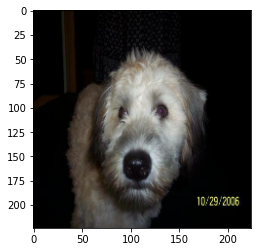

tf.Tensor(b'/content/cats_and_dogs_filtered/validation/cats/cat.2494.jpg', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64) (224, 224, 3)


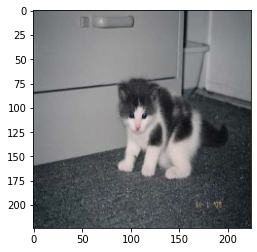

tf.Tensor(b'/content/cats_and_dogs_filtered/validation/dogs/dog.2113.jpg', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64) (224, 224, 3)


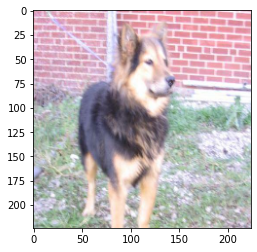

In [45]:
for item in test_ds.take(3):
    print(item)                       # в итераторе путь к конкретной картинке
    image, label = parse_image(item)  # подгрузили картинку 
    print(label, image.shape)                
    plt.imshow(image)                 # нарисовали
    plt.show()

Настроим итераторы для дальнейшей работы с ними. Подробнее про производительность итераторов [читайте в документации.]

In [46]:
norm_img = lambda x,y: (2*(x - tf.reduce_min(x))/(tf.reduce_max(x) - tf.reduce_min(x)) - 1, y)

def configure_for_performance(ds):
    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(norm_img)
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=2000)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Применяем к итераторам все преобразования
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

# То же самое для теста, но его подгружаем по факту целеком
test_ds = test_ds.map(parse_image).map(norm_img).batch(1000).prefetch(tf.data.AUTOTUNE)

Взглянем на первый батч в обучающей выборке.

In [47]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (32, 224, 224, 3)
Label:  [0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0]


In [48]:
image.numpy().min(), image.numpy().max()

(-1.0, 1.0)

## 2.2 Прогнозы

Давайте прогоним текущий батч через нейронку и посмотрим на прогнозы. 

In [49]:
# построим прогнозы по батчу из картинок
result_batch = model.predict(image)

In [51]:
# што там у нас спрогнозировалось?
labels_batch = [item[0] for item in zoo.mobilenet_v2.decode_predictions(result_batch)]

In [52]:
labels_batch[:5]

[('n02123045', 'tabby', 0.60574985),
 ('n02096585', 'Boston_bull', 0.92911524),
 ('n02124075', 'Egyptian_cat', 0.40310082),
 ('n02099712', 'Labrador_retriever', 0.44319403),
 ('n02093428', 'American_Staffordshire_terrier', 0.26602206)]

Посмотрим на  картинки и построенные по ним прогнозы. 

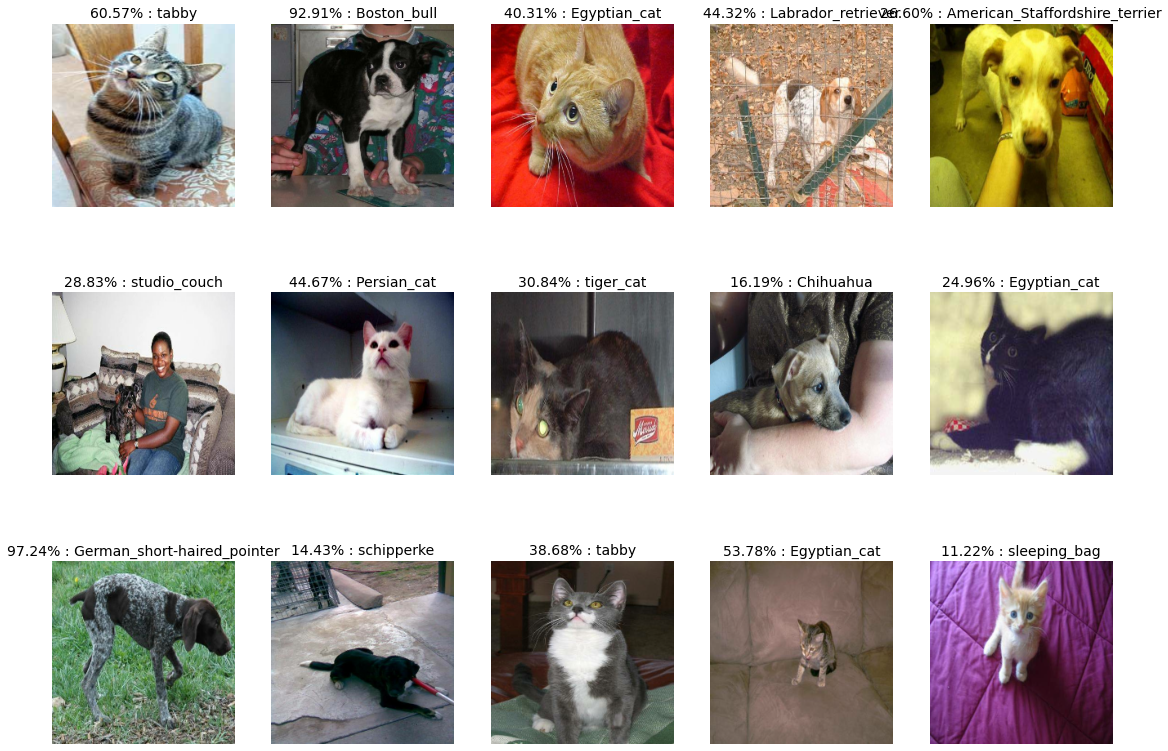

In [53]:
cols = 5
rows = 3
fig = plt.figure(figsize=(4 * cols - 1, 5 * rows - 1))

k = 0 
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow((image[k] + 1)/2)
        ax.set_title("{0:>6.2%} : {1}".format(labels_batch[k][2], labels_batch[k][1]), size=14)
        k += 1
plt.show()

Модель отрабатывает на уровне выше всех похвал (но это неточно).

## 2.3 Дообучаем сетку

Предобученная сетка выдаёт слишком детализированные результаты. Вплоть до породы. Нам нужна информация о том, кот это или собака. Наша задача проще. Давайте доучим нейросеть под наши два класса. Для этого нам придётся срезать с сетки её последние слои. Посмотрим на `summary` модели. 

In [56]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Довольно большое полотно. Давайте срежем в нашей сетки всё до слоя с логитом. Обратимся к слою, который мы хотели бы получить по имени. 

In [57]:
transfer_layer = model.get_layer('global_average_pooling2d')

Выход этого слоя мы будем использовать для создания своей нейронки. Этот слой - обычный тензор. 

In [58]:
transfer_layer.output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

Собираем модель, чтобы получить на выход наш эмбеддинг. 

In [59]:
feature_extractor = Model(
    inputs=model.input,
    outputs=transfer_layer.output
)

Теперь построим на основе экстрактора новую модель. 

In [60]:
# Старт новой модели
new_model = Sequential()

# Первый слой в ней это экстрактор фичей 
new_model.add(feature_extractor)

# можно добавить промежуточные слои, если хочется

# финальный слой 
new_model.add(layers.Dense(1, activation='sigmoid'))

Посмотрим на то, какие слои собрались обучаться. 

In [62]:
def print_layer_trainable():
    for layer in feature_extractor.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
        
print_layer_trainable()    

False:	input_1
False:	Conv1
False:	bn_Conv1
False:	Conv1_relu
False:	expanded_conv_depthwise
False:	expanded_conv_depthwise_BN
False:	expanded_conv_depthwise_relu
False:	expanded_conv_project
False:	expanded_conv_project_BN
False:	block_1_expand
False:	block_1_expand_BN
False:	block_1_expand_relu
False:	block_1_pad
False:	block_1_depthwise
False:	block_1_depthwise_BN
False:	block_1_depthwise_relu
False:	block_1_project
False:	block_1_project_BN
False:	block_2_expand
False:	block_2_expand_BN
False:	block_2_expand_relu
False:	block_2_depthwise
False:	block_2_depthwise_BN
False:	block_2_depthwise_relu
False:	block_2_project
False:	block_2_project_BN
False:	block_2_add
False:	block_3_expand
False:	block_3_expand_BN
False:	block_3_expand_relu
False:	block_3_pad
False:	block_3_depthwise
False:	block_3_depthwise_BN
False:	block_3_depthwise_relu
False:	block_3_project
False:	block_3_project_BN
False:	block_4_expand
False:	block_4_expand_BN
False:	block_4_expand_relu
False:	block_4_depthwise
Fa

Запретим обучать веса внутри нашего экстрактора фичей. Это непозволительная роскошь. Тем более он уже предобучен на `Imagenet.`

In [63]:
feature_extractor.trainable = False

# То же самое но в виде цикла
for layer in feature_extractor.layers:
    layer.trainable = False
    
print_layer_trainable( )

False:	input_1
False:	Conv1
False:	bn_Conv1
False:	Conv1_relu
False:	expanded_conv_depthwise
False:	expanded_conv_depthwise_BN
False:	expanded_conv_depthwise_relu
False:	expanded_conv_project
False:	expanded_conv_project_BN
False:	block_1_expand
False:	block_1_expand_BN
False:	block_1_expand_relu
False:	block_1_pad
False:	block_1_depthwise
False:	block_1_depthwise_BN
False:	block_1_depthwise_relu
False:	block_1_project
False:	block_1_project_BN
False:	block_2_expand
False:	block_2_expand_BN
False:	block_2_expand_relu
False:	block_2_depthwise
False:	block_2_depthwise_BN
False:	block_2_depthwise_relu
False:	block_2_project
False:	block_2_project_BN
False:	block_2_add
False:	block_3_expand
False:	block_3_expand_BN
False:	block_3_expand_relu
False:	block_3_pad
False:	block_3_depthwise
False:	block_3_depthwise_BN
False:	block_3_depthwise_relu
False:	block_3_project
False:	block_3_project_BN
False:	block_4_expand
False:	block_4_expand_BN
False:	block_4_expand_relu
False:	block_4_depthwise
Fa

Последний слой будет обучаться.

In [67]:
new_model.layers[-1].trainable

True

Проверяем запускается ли модель, которую мы собрали и что она выдаёт на выходе.

In [68]:
result = new_model.predict(image)
result.shape

(32, 1)

Теперь наконец мы можем скомпилировать модель. Каждую эпоху (полный проход по данным) в ходе алгоритма обратного распространения ошибки, мы будем обучать только последние слои. Одна эпоха в данном случае - проход по всем картинкам из наших папочек.

In [69]:
new_model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
)

In [70]:
new_model.fit(
    train_ds, validation_data=val_ds,
    epochs=3
)

Epoch 1/3
63/63 [==============================] - 72s 1s/step - loss: 0.1918 - accuracy: 0.9415 - val_loss: 0.1046 - val_accuracy: 0.9650
Epoch 2/3
63/63 [==============================] - 64s 1s/step - loss: 0.0641 - accuracy: 0.9835 - val_loss: 0.0709 - val_accuracy: 0.9750
Epoch 3/3
63/63 [==============================] - 69s 1s/step - loss: 0.0485 - accuracy: 0.9890 - val_loss: 0.0598 - val_accuracy: 0.9800


In [71]:
new_model.evaluate(test_ds)

1/1 [==============================] - 29s 29s/step - loss: 0.0347 - accuracy: 0.9887


[0.03469640389084816, 0.9887499809265137]

__Задание 2:__ 

Постройте с помощью получившейся сетки прогнозы для тестовой выборки, нарисуйте картинки с ними и подписями к ним. Найдите примеры, на которых сетка ошиблась, нарисуйте их.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

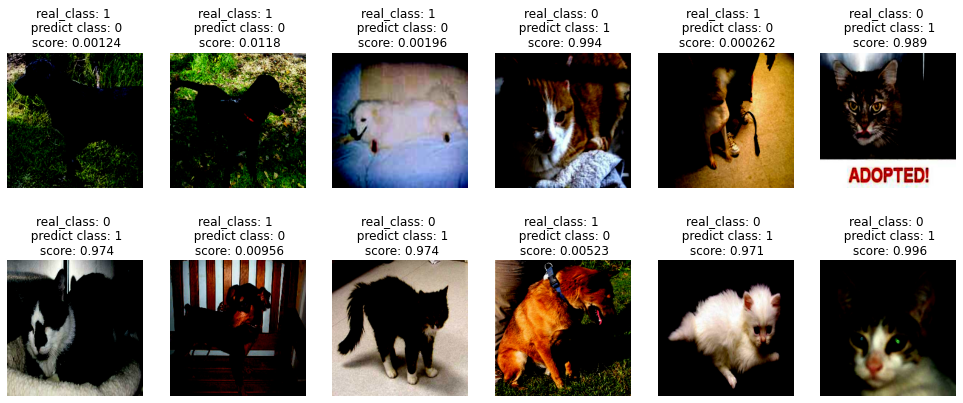

In [72]:
p_pred = new_model.predict(test_ds).T[0]
y_pred = 1*(p_pred > 0.5)

# вся тестовая выборка считывается за 1 итерацию (500 элементов в батче)
for item in test_ds:
    X_test = item[0]
    y_test = item[1]

errors =  y_pred != y_test

X_err = X_test[errors]
y_err = y_test[errors]
y_pred = y_pred[errors]
p_pred = p_pred[errors]


cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {} \n score: {:.3}'.format(y_err[random_index], 
                                                                   y_pred[random_index], np.max(p_pred[random_index])))
plt.show()

__Задание 3:__ 

Вырежьте из предобученной сетки выход из 8 слоя. Дообучите сетку классифицировать котиков. Насколько сильно деградировало качество такой модели? Почему? 

In [74]:
transfer_layer = model.get_layer('block_8_add')

feature_extractor = Model(
    inputs=model.input,
    outputs=transfer_layer.output
)

feature_extractor.trainable = False

new_model_8 = Sequential()
new_model_8.add(feature_extractor)
new_model_8.add(layers.Flatten())
new_model_8.add(layers.Dense(1, activation='sigmoid'))


new_model_8.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['acc']
)

new_model_8.fit(
    train_ds, validation_data=val_ds,
    epochs=3
)

new_model_8.evaluate(test_ds)

Epoch 1/3
63/63 [==============================] - 61s 886ms/step - loss: 1.2490 - acc: 0.7770 - val_loss: 1.5335 - val_acc: 0.7300
Epoch 2/3
63/63 [==============================] - 46s 730ms/step - loss: 0.2562 - acc: 0.9335 - val_loss: 0.9822 - val_acc: 0.8200
Epoch 3/3
1/1 [==============================] - 37s 37s/step - loss: 0.8848 - acc: 0.8575


[0.8848399519920349, 0.8575000166893005]

__Задание 4:__ 

Давайте сделаем всё то же самое, но не будем замораживать промежуточные слои.

In [76]:
transfer_layer = model.get_layer('global_average_pooling2d')

feature_extractor = Model(
    inputs=model.input,
    outputs=transfer_layer.output
)

feature_extractor.trainable = True

new_model_ft = Sequential()
new_model_ft.add(feature_extractor)
new_model_ft.add(layers.Flatten())
new_model_ft.add(layers.Dense(1, activation='sigmoid'))


new_model_ft.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['acc']
)

new_model_ft.fit(
    train_ds, validation_data=val_ds,
    epochs=1
)

new_model_ft.evaluate(test_ds)

1/1 [==============================] - 29s 29s/step - loss: 5.6318 - acc: 0.7750


[5.631801605224609, 0.7749999761581421]

# 3. Tensor hub 

В $2017$ году Google сделал специальную платформу __TensorFlow Hub.__  Она используется для того, чтобы делиться друг с другом моделями. В таком формате свои результаты сохраняют различные исслодовательские группы. В том числе Россияская группа IPavlov. В следующие разы мы будем воровать у них модели через эту библиотечку.  

Сейчас давайте посмотрим как это делается. Для начала нужно установить `tensorflow_hub` на свой компьютер через __pip.__

In [ ]:
!/usr/local/opt/python@3.9/bin/python3.9 -m pip install tensorflow_hub

     |████████████████████████████████| 108 kB 727 kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)
print(hub.__version__)

2.5.0
0.12.0


 Дальше мы можем завернуть её в удобную функцию и начать применять. 

In [ ]:
IMAGE_SHAPE = [224, 224]

classifier = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape=IMAGE_SHAPE+[3])
])

In [ ]:
# input shape такой, потому что три канала
IMAGE_SHAPE + [3]

[224, 224, 3]

In [ ]:
classifier.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


Запустим сетку на изображении. 

In [ ]:
href = 'https://sadanduseless.b-cdn.net/wp-content/uploads/2019/06/cat-breading4.jpg'
image = get_file('cat.jpg', href)

print(image) # куда скачался то?! 

image = PIL.Image.open(image).resize(input_shape)
image = np.array(image)/255

classifier.predict(image[np.newaxis, ...])

/Users/fulyankin/.keras/datasets/cat.jpg


array([[ 0.12381458, -0.7201803 , -0.13566592, ..., -0.9659192 ,
         0.21174961,  2.1669633 ]], dtype=float32)

При желании можно узнать что за класс получился на выходе по аналогии с тем, как мы сделали это в самом начале тетрадки.

## 3.2 Дообучаем сетку

Доучивать её мы будем на тех же самых данных по хотдогам. 

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

Посмотрим что будет идти из этого экстрактора на выход. 

In [ ]:
image.shape

(224, 224, 3)

In [ ]:
feature_batch = feature_extractor_layer(image[None, :, :, :])
print(feature_batch.shape)

(1, 1280)


Запретим tensorflow тренировать веса экстрактора.

In [ ]:
feature_extractor_layer.trainable = False

Cобираем модель, на последний слой вытаскиваем softmax на 7 классов


In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# проверяем запускается ли модель, которую мы собрали и что она выдаёт на выходе
result = model.predict(image[None, :, :, :])
result.shape

(1, 2)

Собираем модель и запускаем обучение.

In [ ]:
# Поменять на код который выше был! 

# model.compile(
#       optimizer=tf.keras.optimizers.Adam(),
#       loss='categorical_crossentropy',
#       metrics=['acc']
# )

# # число шагов до конца первой эпохи
# steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

# # учим сетку одну эпоху
# model.fit(image_data, epochs=3, 
#             steps_per_epoch = steps_per_epoch)

По аналогии с кодом выше можно посмотреть что наша модель будет прогнозировать. Не будем копипастить. Лучше сделаем другую вещь. Мы довольно долго учили модельку. Давайте её сохраним на компьютер. Модели на комп можно сохранять в разных видах и форматах. Про это ещё поговорим.

In [ ]:
export_path = tf.keras.models.save_model(model, "./saved_models")
export_path

In [ ]:
!ls saved_models

Обратите внимание, что мы здесь не дробили выборку на трэйн и тест, а просто дообучали сетку сразу и на всём. Делали мы это для того, чтобы тетрадка выглядела попроще. В домашке вы заведёте себе два генератора. Один для трэйна, второй для теста. И побегут эпохи для обучения сеток.


## Почиташки 

Делал этут тетрадку на основе двух туториалов: 

* [Первый,](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/10_Fine-Tuning.ipynb)  на этом гитхабе довольно большое количество крутых тетрадок про нейронки. Рекомендую позалипать на них. 
* [Документация Tensorflow_Hub](https://www.tensorflow.org/hub) и [пример](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) её применения на цветочках
* [Пример извлечения фичей для SWM из нейронки,](https://www.kaggle.com/craigglastonbury/using-inceptionv3-features-svm-classifier) если вдруг это кого-то заинтересовало.